In [1]:
import pandas as pd

# Loading CSV files into a DataFrame
customer_data = pd.read_csv('CustomerDataTable.csv')
purchase_history = pd.read_csv('PurchaseHistoryTable.csv')
product_details = pd.read_csv('ProductDetailsTable.csv')

# Checking the first few rows to ensure data is loaded properly
print(customer_data.head())
print(purchase_history.head())
print(product_details.head())

   Customer_ID  Age  Gender       Location
0          101   25    Male       New York
1          102   30  Female    Los Angeles
2          103   22    Male        Chicago
3          104   28  Female  San Francisco
4          105   35    Male        Seattle
   Transaction_ID  Customer_ID  Product_ID Purchase_Date  Rating
0            1001          101        2001     15-Jul-23       5
1            1002          102        2003     16-Jul-23       4
2            1003          103        2002     17-Jul-23       4
3            1004          104        2004     18-Jul-23       3
4            1005          105        2001     19-Jul-23       5
   Product_ID       Product_Name     Category
0        2001         Smartphone  Electronics
1        2002  Fashionable Watch      Fashion
2        2003             Laptop  Electronics
3        2004     Athletic Shoes       Sports
4        2005       Fiction Book        Books


In [2]:
# Merging purchase history with product details using 'Product_ID'
merged_data = pd.merge(purchase_history, product_details, on='Product_ID', how='inner')

# Merging the result with customer data using 'Customer_ID'
merged_data = pd.merge(merged_data, customer_data, on='Customer_ID', how='inner')

# displaying the final merged dataset
print(merged_data.head())

   Transaction_ID  Customer_ID  Product_ID Purchase_Date  Rating  \
0            1001          101        2001     15-Jul-23       5   
1            1002          102        2003     16-Jul-23       4   
2            1003          103        2002     17-Jul-23       4   
3            1004          104        2004     18-Jul-23       3   
4            1005          105        2001     19-Jul-23       5   

        Product_Name     Category  Age  Gender       Location  
0         Smartphone  Electronics   25    Male       New York  
1             Laptop  Electronics   30  Female    Los Angeles  
2  Fashionable Watch      Fashion   22    Male        Chicago  
3     Athletic Shoes       Sports   28  Female  San Francisco  
4         Smartphone  Electronics   35    Male        Seattle  


In [3]:
#Checking for missing values
print(merged_data.isnull().sum())

Transaction_ID    0
Customer_ID       0
Product_ID        0
Purchase_Date     0
Rating            0
Product_Name      0
Category          0
Age               0
Gender            0
Location          0
dtype: int64


In [4]:
# Summarizing the data statistics
print(merged_data.describe())

       Transaction_ID  Customer_ID   Product_ID     Rating        Age
count        10.00000     10.00000    10.000000  10.000000  10.000000
mean       1005.50000    105.50000  2002.600000   4.100000  30.000000
std           3.02765      3.02765     1.429841   0.737865   5.142416
min        1001.00000    101.00000  2001.000000   3.000000  22.000000
25%        1003.25000    103.25000  2001.250000   4.000000  27.250000
50%        1005.50000    105.50000  2002.500000   4.000000  29.500000
75%        1007.75000    107.75000  2003.750000   4.750000  32.500000
max        1010.00000    110.00000  2005.000000   5.000000  40.000000


In [5]:
# lets do EDA
# 1.Displaying unique users and items
print(f'Number of unique users: {merged_data["Customer_ID"].nunique()}')
print(f'Number of unique items: {merged_data["Product_ID"].nunique()}')

Number of unique users: 10
Number of unique items: 5


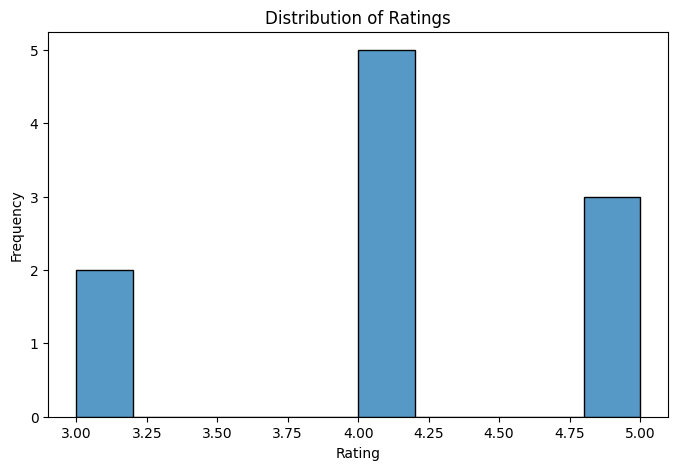

In [6]:
# 2. Distribution of Ratings

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.histplot(merged_data['Rating'], bins=10, kde=False)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


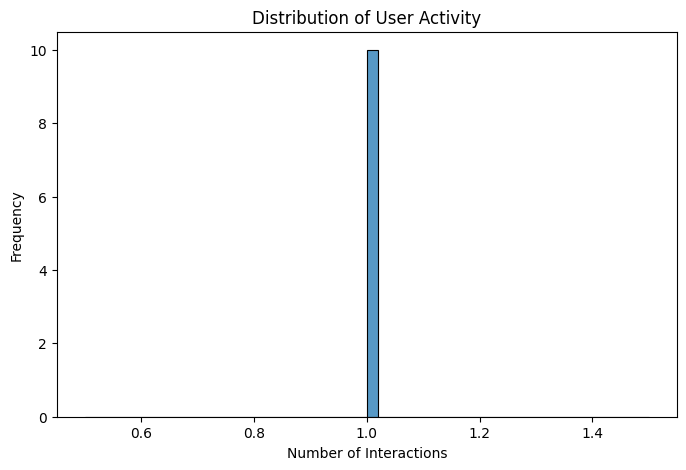

In [7]:
# 3.Distribution of Interactions per User ( displaying User Acitivity)
#Checking how active users are in interacting with the platform (e.g., how many ratings/purchases they make).

user_activity = merged_data.groupby('Customer_ID').size()
plt.figure(figsize=(8, 5))
sns.histplot(user_activity, bins=50, kde=False)
plt.title('Distribution of User Activity')
plt.xlabel('Number of Interactions')
plt.ylabel('Frequency')
plt.show()



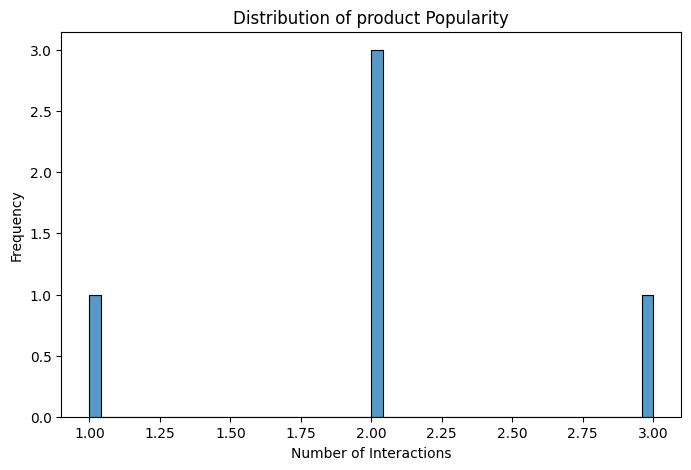

count    5.000000
mean     2.000000
std      0.707107
min      1.000000
25%      2.000000
50%      2.000000
75%      2.000000
max      3.000000
dtype: float64


In [8]:
# 4. Product Popularity: Distribution of Interactions per Product
# Visualizing which products are the most popular (based on the number of interactions).

product_popularity = merged_data.groupby('Product_ID').size()
plt.figure(figsize=(8, 5))
sns.histplot(product_popularity, bins=50, kde=False)
plt.title('Distribution of product Popularity')
plt.xlabel('Number of Interactions')
plt.ylabel('Frequency')
plt.show()
print(product_popularity.describe())


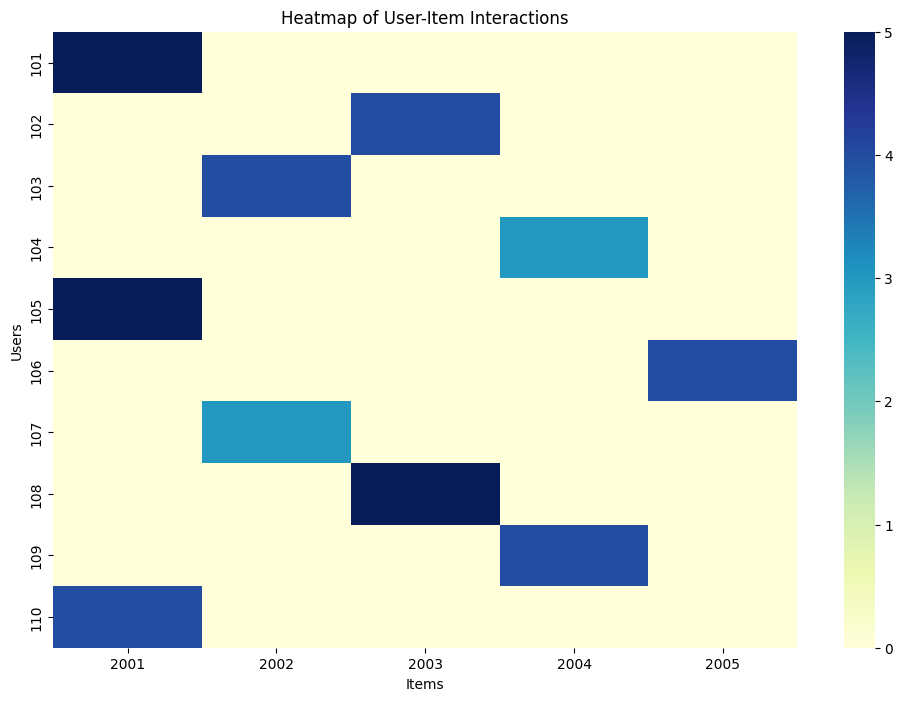

In [9]:
# 5. Heatmap of customer-product Interactions
# Visualizing a small portion of the customer-product interaction matrix to get an idea of the density of interactions.

subset_data = merged_data.head(1000)  # Sample of 1000 interactions for visualization
user_item_matrix_subset = subset_data.pivot(index='Customer_ID', columns='Product_ID', values='Rating').fillna(0) # User-Item matrix
plt.figure(figsize=(12, 8))
sns.heatmap(user_item_matrix_subset, cmap="YlGnBu")
plt.title('Heatmap of User-Item Interactions')
plt.xlabel('Items')
plt.ylabel('Users')
plt.show()


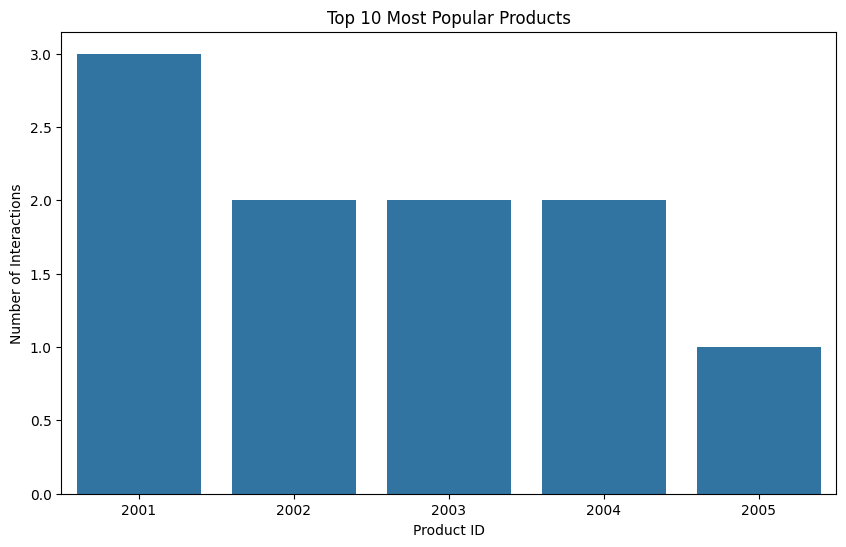

In [10]:
# 6. Top 10 Most Popular Products

top_products = merged_data['Product_ID'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_products.index, y=top_products.values)
plt.title('Top 10 Most Popular Products')
plt.xlabel('Product ID')
plt.ylabel('Number of Interactions')
plt.show()

In [11]:
# We are done with the EDA part...Lets start building our recommender model

# lets Build User-Item Matrix:
# Step 1: lets create a user-item rating matrix (pivot table)
ratings_matrix = merged_data.pivot_table(index='Customer_ID', columns='Product_ID', values='Rating')

# Filling NaN values with 0 to represent that the user hasn't rated that product yet
ratings_matrix_filled = ratings_matrix.fillna(0)

In [13]:
# Step 2: Calculating item-item similarity using cosine similarity

from sklearn.metrics.pairwise import cosine_similarity
item_similarity = cosine_similarity(ratings_matrix_filled.T)  # Transpose to get item-item similarities
item_similarity_df = pd.DataFrame(item_similarity, index=ratings_matrix_filled.columns, columns=ratings_matrix_filled.columns)


In [15]:
# Step 3: Predict ratings using weighted average of similar items

import numpy as np
def predict_ratings(ratings_matrix, similarity_matrix):
    # Dot product of ratings and similarity to predict ratings
    ratings_pred = np.dot(ratings_matrix, similarity_matrix) / np.array([np.abs(similarity_matrix).sum(axis=1)])
    return ratings_pred

# Get the predicted ratings
ratings_pred = predict_ratings(ratings_matrix_filled.values, item_similarity)

# Convert the predicted ratings to a DataFrame
ratings_pred_df = pd.DataFrame(ratings_pred, index=ratings_matrix_filled.index, columns=ratings_matrix_filled.columns)

In [16]:
# Step 4: Evaluate the model using MSE

from sklearn.metrics import mean_squared_error
actual_ratings = ratings_matrix_filled.values[ratings_matrix_filled.values.nonzero()]
predicted_ratings = ratings_pred[ratings_matrix_filled.values.nonzero()]
mse = mean_squared_error(actual_ratings, predicted_ratings)
print(f'Mean Squared Error (MSE) of the Item-based Collaborative Filtering Model: {mse}')

Mean Squared Error (MSE) of the Item-based Collaborative Filtering Model: 0.0


In [17]:
# Step 5: lets get recommendations for a user

def get_recommendations_for_user(user_id, ratings_matrix, ratings_pred, product_details, top_n=3):
    # Get the user's actual ratings
    user_ratings = ratings_matrix.loc[user_id]

    # Get the predicted ratings for the user
    user_predicted_ratings = ratings_pred_df.loc[user_id]

    # Recommend top-N items that the user hasn't rated yet
    unrated_items = user_ratings[user_ratings == 0].index  # Items that are not rated by the user
    recommended_items = user_predicted_ratings.loc[unrated_items].nlargest(top_n)  # Top N items by predicted ratings

    # Retrieve product details (e.g., Product Name and Category) for the recommended items
    recommended_products = product_details[product_details['Product_ID'].isin(recommended_items.index)]

    return recommended_products[['Product_ID', 'Product_Name', 'Category']]

In [18]:
# Step 6: Now i am trying to get recommendations for a specific user(say user 101)

user_id = 101
top_n = 3
recommended_items = get_recommendations_for_user(user_id, ratings_matrix_filled, ratings_pred, product_details, top_n)


In [19]:
# lets display the recommended items and their categories
print(f"\nTop {top_n} recommendations for user {user_id}:")
print(recommended_items)


Top 3 recommendations for user 101:
   Product_ID       Product_Name     Category
1        2002  Fashionable Watch      Fashion
2        2003             Laptop  Electronics
3        2004     Athletic Shoes       Sports


In [20]:
# lets do some fine tuning (hyper parameter tuning)
#Compute item-item similarity using different metrics (fine-tuning)

def compute_similarity(ratings_matrix, metric='cosine'):
    if metric == 'cosine':
        similarity = cosine_similarity(ratings_matrix.T)
    elif metric == 'pearson':
        similarity = np.corrcoef(ratings_matrix.T)
    elif metric == 'adjusted_cosine':
        # Subtracting the mean rating of each user from their ratings
        user_means = ratings_matrix.mean(axis=1)
        ratings_matrix_normalized = ratings_matrix.sub(user_means, axis=0)
        similarity = cosine_similarity(ratings_matrix_normalized.T)
    else:
        raise ValueError("Invalid similarity metric")
    return similarity


In [30]:
# Predict ratings with the chosen similarity metric

def predict_ratings(ratings_matrix, similarity_matrix):
    
    # Add a small constant (epsilon) to avoid division by zero
    epsilon = 1e-9
    sum_of_similarities = np.array([np.abs(similarity_matrix).sum(axis=1)]) + epsilon
    ratings_pred = np.dot(ratings_matrix, similarity_matrix) / sum_of_similarities
    
    # Handle NaNs in the predicted ratings by filling them with the average rating
    ratings_pred = np.nan_to_num(ratings_pred, nan=ratings_matrix.mean().mean())
    
    return ratings_pred

In [31]:
# Computing item-item similarity using different metrics
def compute_similarity(ratings_matrix, metric='cosine'):
    if metric == 'cosine':
        similarity = cosine_similarity(ratings_matrix.T)
    else:
        raise ValueError("Invalid similarity metric")
    return similarity

In [32]:
# Cross-validation for error evaluation

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold

def cross_validate_recommendations(ratings_matrix, similarity_metric='cosine', k_folds=5):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=1)
    mse_scores = []
    rmse_scores = []
    mae_scores = []

    for train_index, test_index in kf.split(ratings_matrix):
        train_ratings = ratings_matrix.iloc[train_index]
        test_ratings = ratings_matrix.iloc[test_index]

        # Compute similarity based on the chosen metric
        similarity_matrix = compute_similarity(train_ratings, metric=similarity_metric)

        # Predict ratings for the test set
        predicted_ratings = predict_ratings(train_ratings.values, similarity_matrix)
        
        # Convert to DataFrame
        predicted_ratings_df = pd.DataFrame(predicted_ratings, index=train_ratings.index, columns=train_ratings.columns)

        # Evaluate errors (on non-zero actual ratings)
        test_actual = test_ratings.values[test_ratings.values.nonzero()]
        test_predicted = predicted_ratings[test_ratings.values.nonzero()]

        # Clean up any NaNs in the predicted values
        test_predicted = np.nan_to_num(test_predicted, nan=0)

        # Calculate error metrics
        mse = mean_squared_error(test_actual, test_predicted)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(test_actual, test_predicted)

        mse_scores.append(mse)
        rmse_scores.append(rmse)
        mae_scores.append(mae)

    return np.mean(mse_scores), np.mean(rmse_scores), np.mean(mae_scores)

In [33]:
# again a Function to get recommendations for a user after fine tuning and cross validation

def get_recommendations_for_user(user_id, ratings_matrix, ratings_pred, product_details, top_n=3):
    user_ratings = ratings_matrix.loc[user_id]
    user_predicted_ratings = pd.DataFrame(ratings_pred, index=ratings_matrix.index, columns=ratings_matrix.columns).loc[user_id]

    # Recommend top-N items that the user hasn't rated yet
    unrated_items = user_ratings[user_ratings == 0].index
    recommended_items = user_predicted_ratings.loc[unrated_items].nlargest(top_n)

    # Retrieve product details for the recommended items
    recommended_products = product_details[product_details['Product_ID'].isin(recommended_items.index)]

    return recommended_products[['Product_ID', 'Product_Name', 'Category']]

In [37]:
# Performing cross-validation and optimizing the recommendation system

metrics = ['cosine']
best_metric = None
best_mse = float('inf')

print("Cross-validation results:")
for metric in metrics:
    mse, rmse, mae = cross_validate_recommendations(ratings_matrix_filled, similarity_metric=metric, k_folds=5)
    print(f"Metric: {metric} | MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")
    if mse < best_mse:
        best_mse = mse
        best_metric = metric

print(f"\nBest similarity metric: {best_metric} with MSE: {best_mse:.4f}")

Cross-validation results:
Metric: cosine | MSE: 14.8000 | RMSE: 3.7544 | MAE: 3.6000

Best similarity metric: cosine with MSE: 14.8000


In [38]:
# Lets et recommendations for a specific user with the best similarity metric

similarity_matrix_best = compute_similarity(ratings_matrix_filled, metric=best_metric)
ratings_pred_best = predict_ratings(ratings_matrix_filled.values, similarity_matrix_best)

user_id = 101
top_n = 3
recommended_items = get_recommendations_for_user(user_id, ratings_matrix_filled, ratings_pred_best, product_details, top_n)

# Display the recommended items and their categories
print(f"\nTop {top_n} recommendations for user {user_id}:")
print(recommended_items)


Top 3 recommendations for user 101:
   Product_ID       Product_Name     Category
1        2002  Fashionable Watch      Fashion
2        2003             Laptop  Electronics
3        2004     Athletic Shoes       Sports
